In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from pyfrac.utils.sofiutils import *
# from pyfrac.hydrafrac.acquisition import recgeom
from pyfrac.visualisation.plotting_support import explode_volume

# VELOCITY MODEL CREATION 

In [2]:
def plot_XYslice(vp_mod_sty, expname, abs_bounds):
    fig,ax = plt.subplots(1,1,figsize=[5,5])
    c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,0,:-abs_bounds].T, 
                  aspect='auto', cmap='copper', vmax=np.max(vp_mod), vmin=np.min(vp_mod),
                 )
    plt.colorbar(c, label='Vp [ms-1]')
    ax.set_title(expname); ax.set_ylabel('y [cm]'); ax.set_xlabel('x [cm]');
    return fig

In [3]:
model_outpath = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI-modelling/pyfrac_SOFIModelling/inputs/models'
rec_outpath = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI-modelling/pyfrac_SOFIModelling/inputs'

------------------

# Rock Properties - subsurface models

In [4]:
abs_bounds = 30 # boundary points

dx = dy = dz = 5

nx = 52+2*abs_bounds
ny = 68+2*abs_bounds
nz = 90+abs_bounds

x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz  


In [5]:
max(z)

595

In [6]:
# Subsurface properties
homo_vp = 1000  # m/s
homo_vs = homo_vp/1.61
homo_rho =  1000 * (0.31*homo_vp**0.25)


In [7]:
layered_vp = [800, 900, 1000]  # m/s
layered_interfaces = [200,400]

--------------

# HOMOGENEOUS MODEL

(112, 128, 120)


(<Figure size 800x800 with 5 Axes>,
 (<Axes: xlabel='x samples', ylabel='z samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

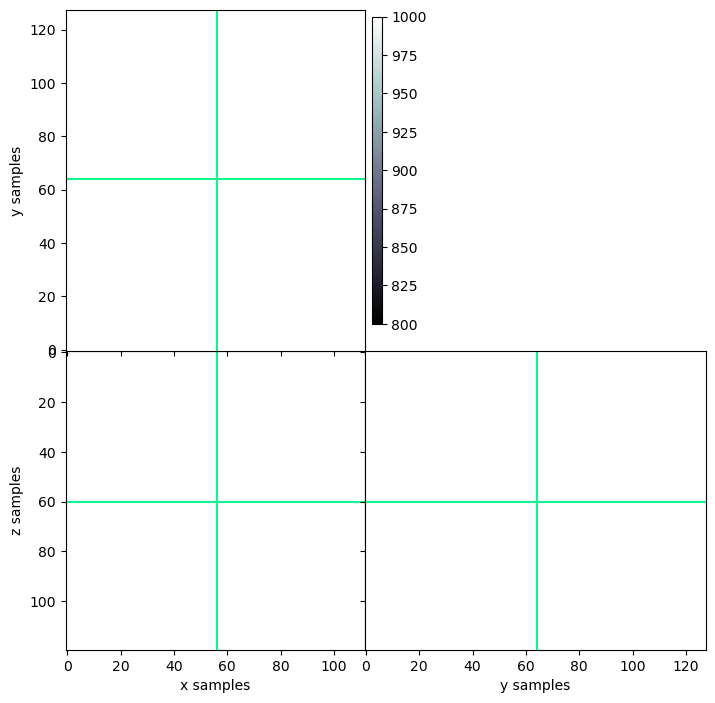

In [8]:
vp_mod = homo_vp * np.ones([nx,ny,nz])
vs_mod = homo_vs * np.ones([nx,ny,nz])
rho_mod = homo_rho * np.ones([nx,ny,nz])
print(vp_mod.shape)

# # Write as binary
expname = 'Homogeneous'
vp_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.vp'%expname))#,format='<f')
vs_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.vs'%expname))  #,format='<f')
rho_mod.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.rho'%expname))  #,format='<f')

explode_volume(vp_mod.transpose([2,0,1]), x=nx//2, y=ny//2, clipval=[min(layered_vp),max(layered_vp)],tlabel='z')

In [9]:
print(vp_mod.shape)

(112, 128, 120)


In [10]:
print(nx/8, ny/8, nz/8)

14.0 16.0 15.0


----------------

# 3 Layer VMod

In [11]:
expname = 'ThreeLayer'
vp3L_1D  = layered_vp[0] * np.ones(nz)
vp3L_1D[int(layered_interfaces[0]/dz):] = layered_vp[1]
vp3L_1D[int(layered_interfaces[1]/dz):] = layered_vp[2]

vp_3L = np.expand_dims(vp3L_1D, axis=[0,1])
vp_3L = vp_3L.repeat(nx,axis=0).repeat(ny,axis=1)

vs_3L = vp_3L/1.61
rho_3L =  1000 * (0.31*vp_3L**0.25)

vp_3L.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.vp'%expname))#,format='<f')
vs_3L.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.vs'%expname))  #,format='<f')
rho_3L.astype(np.float32).tofile(os.path.join(model_outpath,'%s_xyz.rho'%expname))  #,format='<f')


(<Figure size 800x800 with 5 Axes>,
 (<Axes: xlabel='x samples', ylabel='z samples'>,
  <Axes: xlabel='y samples'>,
  <Axes: ylabel='y samples'>))

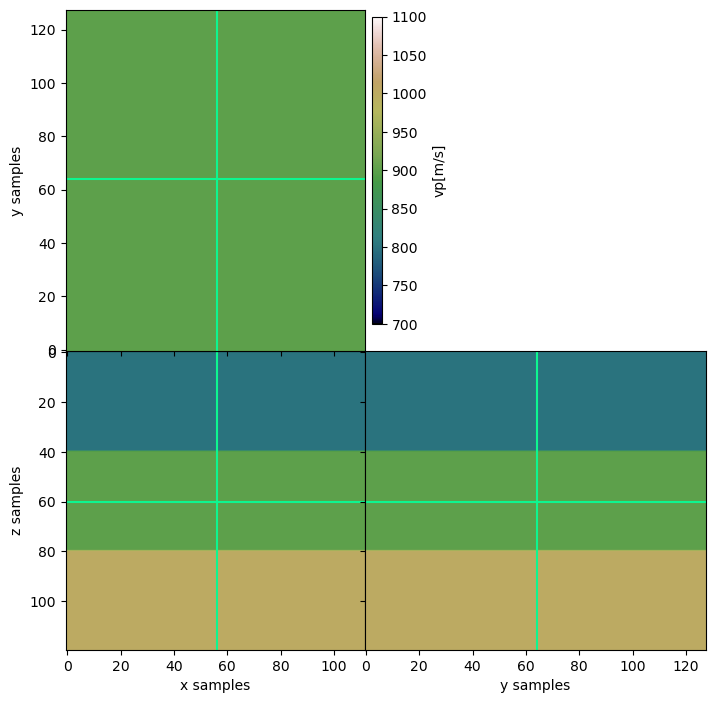

In [12]:
explode_volume(vp_3L.transpose([2,0,1]), x=nx//2, y=ny//2, clipval=[700,1100],
               cmap='gist_earth', cbarlabel='vp[m/s]', tlabel='z')

----------------------------

# Source Location

In [13]:
sx = x[nx//2]
sy = y[ny//2]
sz = z[2*nz//3]
print(sx,sy,sz)

td = 1e-4  # ignition time
fc = 20  # central frequency
amp = 1.  # amplitude

string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]

# SOURCE FILE
sourcefile = os.path.join(rec_outpath,'centralsource.dat')
text_file = open(sourcefile, "wt")
text_file.writelines('\t'.join(string_list))
text_file.close()

280 320 400


# Receiver Array

In [14]:
# RECEIVERS

grid_rx_locs = np.arange(sx-100, sx+101, 20)
grid_ry_locs = np.arange(sy-120, sy+121, 20)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), rz.flatten(), ry.flatten()))
nr = recs.shape[1]

recfile = os.path.join(rec_outpath,'surfacearray_xzy_20m.dat')
np.savetxt(recfile,
           recs.T.astype(np.float32), 
           fmt='%.4f')

In [15]:
vp_3L.shape

(112, 128, 120)

-------------

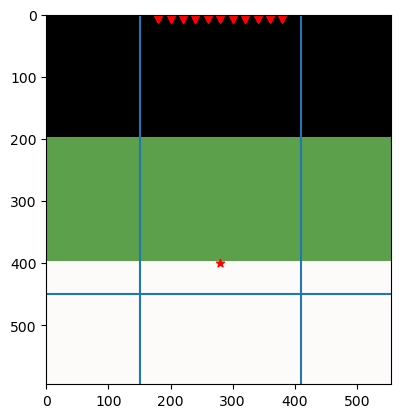

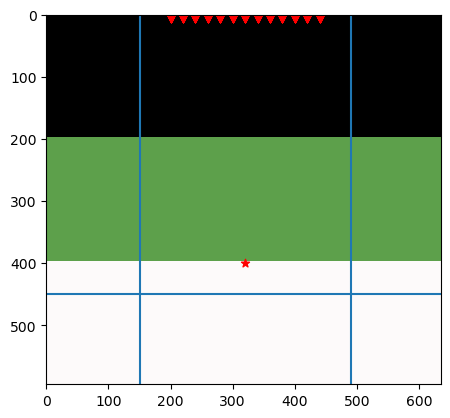

In [16]:
fig,ax = plt.subplots(1,1)
ax.imshow(vp_3L[:,0].T,cmap='gist_earth', vmin=800, vmax=1000, extent=[min(x),max(x), max(z), min(z)])
ax.scatter(rx,rz,c='r', marker='v')
ax.scatter(sx,sz,c='r', marker='*')
ax.axvline(30*dx)
ax.axvline((nx-30)*dx)
ax.axhline((nz-30)*dz)

fig,ax = plt.subplots(1,1)
ax.imshow(vp_3L[0].T,cmap='gist_earth', vmin=800, vmax=1000, extent=[min(y),max(y), max(z), min(z)])
ax.scatter(ry,rz,c='r', marker='v')
ax.scatter(sy,sz,c='r', marker='*')
ax.axvline(30*dx)
ax.axvline((ny-30)*dx)
ax.axhline((nz-30)*dz)

--------------------------------

# WRITE SOFI FILES

In [17]:
project_dir = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI-modelling/pyfrac_SOFIModelling'

In [18]:
# Time paramets
dt = 5e-4
dur = 1

# SNAP PARAMETERS
snap_start = dt
snap_end = dur/2
snap_step = 100*dt
tsnap_params = [snap_start, snap_end, snap_step]
snap_sbsmp_xyz = 2

smgrm_ndt = 2

In [19]:
# GET THE DIFFERENT STRINGS - this will be updated in the future
default_strs = get_default_strings(rec_file=recfile)

# MODELLING
t_str = get_time_str(dt, dur)

bndry_str = get_boundary_str(fs=True, 
                             npad=abs_bounds, 
                             cpml=True)


threeL_mod_strs = get_subsurfmod_str([nx,nz,ny], 
                              [dx,dz,dy],
                              expname,
                              moddir=model_outpath+'/ThreeLayer_xyz',
                             )

In [20]:
# SOURCE
src_str_exp = get_source_str(sfile=sourcefile)
# src_str_MT1 = get_MTsource_str(strike, dip, rake, sfile=sourcefile)

### Homo - Explosive

### Homo - 0 45 90

In [21]:
# expname = 'homo_MT_0_45_90'
expname = 'homo_MT_0_90_0'

strike, dip, rake = 0., 45., 90.
src_str_MT1 = get_MTsource_str(strike, dip, rake, sfile=sourcefile)

# SNAP & SEISMOGRAM
monitor_strs = get_monitor_str(tsnap_params, 
                               smgrm_ndt, 
                               expname, 
                               sbsmp_xyz=snap_sbsmp_xyz,
                              snap=True)

homo_mod_strs = get_subsurfmod_str([nx,nz,ny], 
                              [dx,dz,dy],
                              expname,
                              moddir=model_outpath+'/Homogeneous_xyz',
                             )
exp_SOFIjsonfilename = os.path.join(project_dir,'%s.json'%expname)
write_SOFIjsonParams = write_SOFIjsonParams(default_strs, 
                                            monitor_strs,  
                                            t_str, 
                                            homo_mod_strs, 
                                            src_str_MT1, 
                                            bndry_str, 
                                            exp_SOFIjsonfilename)

sofimaster = '~/Documents/Projects/MicroseismicModelling/SOFI3D-master/bin/'
num_procs = 8
shellfilename = os.path.join(project_dir,'runSOFI3D_%s.sh'%expname)

runscript = write_SOFIrunScript(sofimaster, 
                                num_procs, 
                                exp_SOFIjsonfilename.split('/')[-1], 
                                shellfilename)